In [1]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet as proph
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 84045 (Saratoga Springs, UT)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Saratoga = melted[melted.RegionName == 84045]

In [6]:
Saratoga

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
1996-05-31,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,200850.0
1996-06-30,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,200187.0
1996-07-31,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,200241.0
1996-08-31,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,198823.0
1996-09-30,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,198150.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,484424.0
2021-04-30,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,498070.0
2021-05-31,84045,399650,5961,Saratoga Springs,UT,Provo-Orem,Utah County,Zip,UT,514395.0


In [7]:
Saratoga = Saratoga.resample('MS').mean()
Saratoga = Saratoga.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

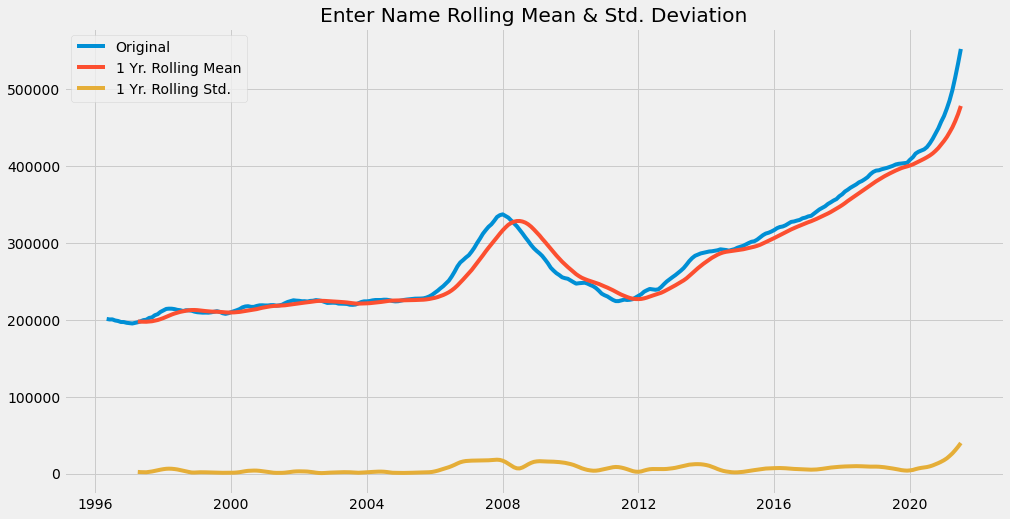

In [8]:
roll_mean_std(Saratoga)

### Seasonal Decompose

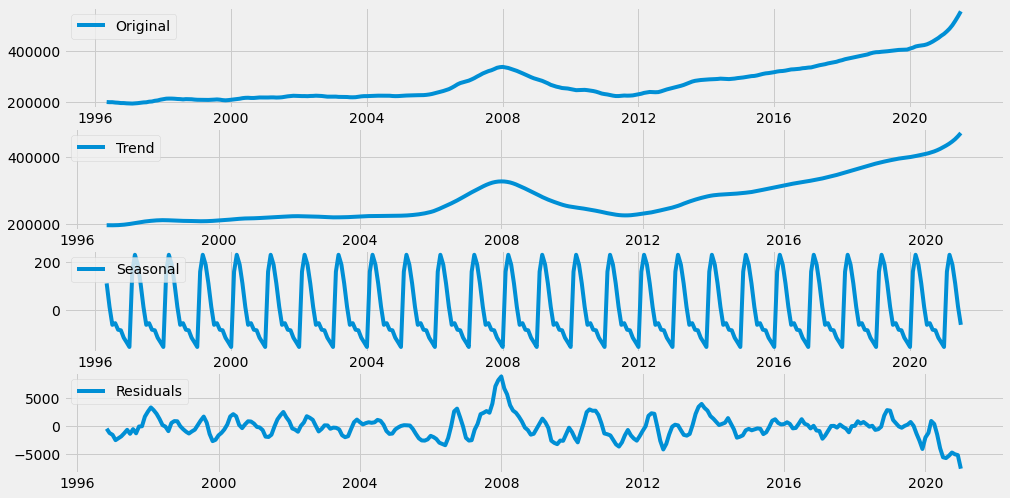

In [9]:
decompose(Saratoga)

### Differencing and DickeyFuller Test

In [10]:
DickeyFullerTest(Saratoga)

Test Statistic                   2.329205
p-value                          0.998973
# Lags Used                     16.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64

Test Statistic                  -0.721139
p-value                          0.841198
# Lags Used                     16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64

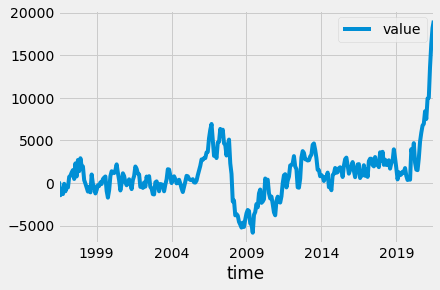

In [11]:
Saratoga_diff = Saratoga.diff().dropna()
Saratoga_diff.plot()
DickeyFullerTest(Saratoga_diff)

Test Statistic                  -2.565152
p-value                          0.100416
# Lags Used                     15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64

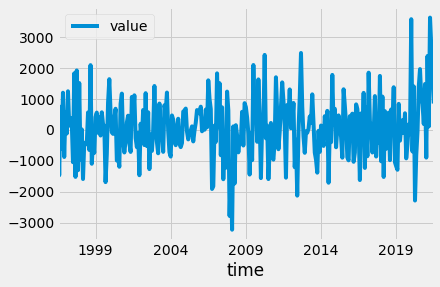

In [12]:
Saratoga_diff2 = Saratoga_diff.diff().dropna()
Saratoga_diff2.plot()
DickeyFullerTest(Saratoga_diff2)

Test Statistic                  -5.324884
p-value                          0.000005
# Lags Used                     16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64

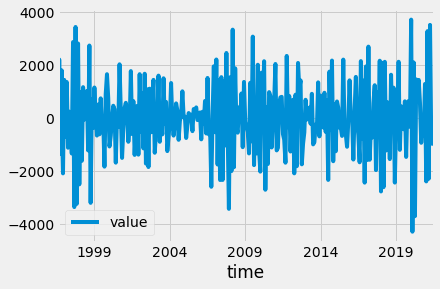

In [13]:
Saratoga_diff3 = Saratoga_diff2.diff().dropna()
Saratoga_diff3.plot()
DickeyFullerTest(Saratoga_diff3)

### ACF and PACF

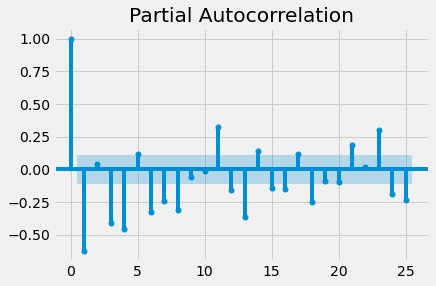

In [14]:
plot_pacf(Saratoga_diff3);

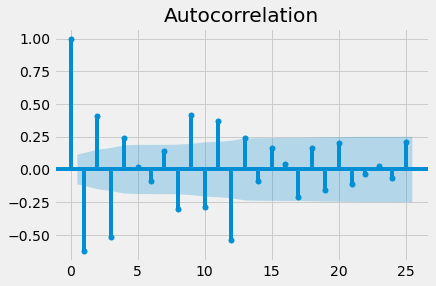

In [15]:
plot_acf(Saratoga_diff3);

### Train Test Split

In [16]:
cutoff = round(Saratoga.shape[0]*.8)
train = Saratoga[:cutoff]
test = Saratoga[cutoff:]

### Naive Model

The Naive Model RMSE for the train data is: 2301.1
The Naive Model RMSE for the test data is: 5587.37


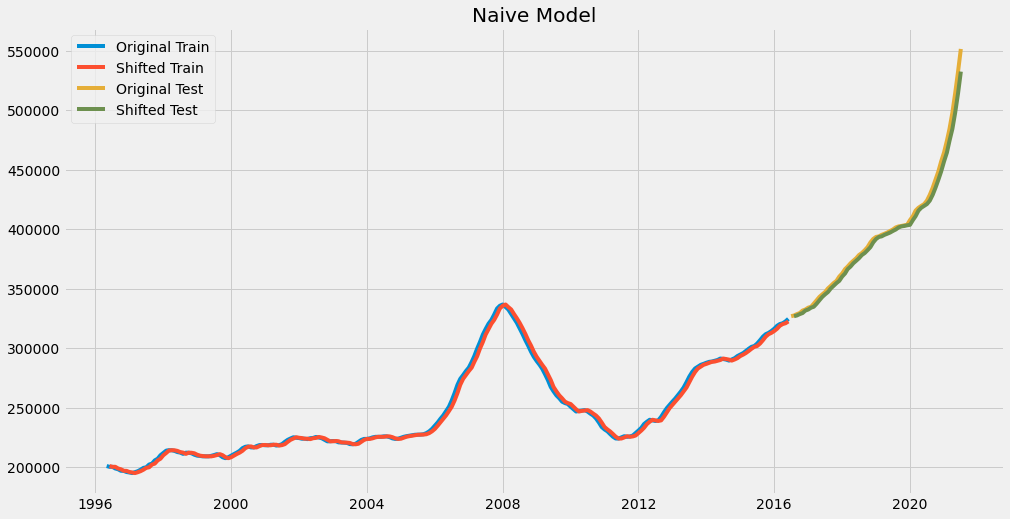

In [17]:
naive_model(train, test)

The RMSE for the Naive model (shifted one time step) is 2301.  Let's move on to the ARIMA models.

## Arima Model

### Random Walk Model

In [18]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
y_hat = random_walk_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], y_hat[1:]))
RMSE

2301.1028449212267

The Random Walk model has the same RMSE as the Naive model.  Let's try Auto ARIMA to select a SARIMAX model.

### Auto ARIMA

In [19]:
auto_Saratoga = pm.auto_arima(train, 
                                  start_p=0,
                                  start_q=0,
                                  max_p=10,
                                  max_q=10,
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  start_Q=0,
                                  max_P=10,
                                  max_Q=10,
                                  m=12,
                                  D=None,
                                  test='kpss',
                                  trace=True,
                                  stepwise=True,
                                  n_fits=1000)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4406.837, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4408.441, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4405.678, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4417.162, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4404.417, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4405.703, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4407.578, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4389.653, Time=0.77 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4403.061, Time=1.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4402.986, Time=1.27 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4407.245, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=4404.335, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[12] inte

In [20]:
sarimax_model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE

6077.791725468998

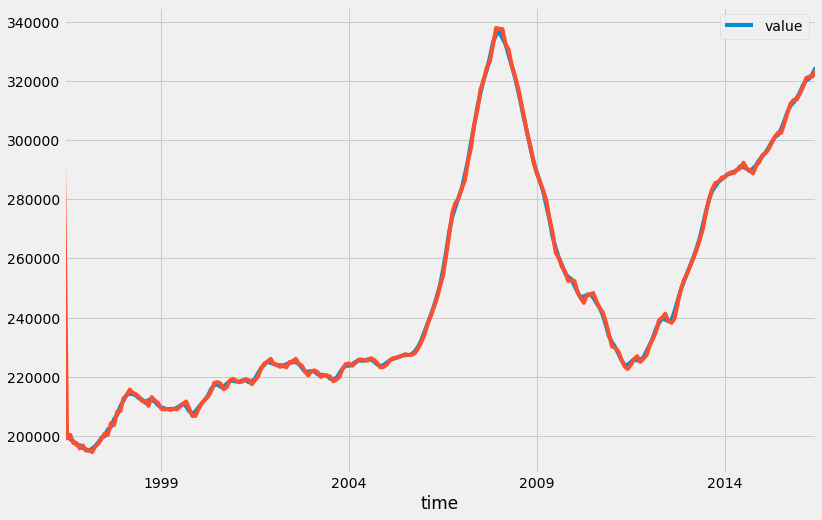

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
train[1:].plot(ax=ax)
yhat_train[1:].plot(ax=ax);

The model matches the train set well, though something is happening with the earliest prediction (i.e. it's predicting high values for the earliest home values.) Let's try a brute force SARIMAX search.

### SARIMAX GridSearch and Model

In [22]:
sarimax_search(train, p=range(0,2), d=range(0,2), q=range(0,2), maxiter=100)

THERE ARE 64 ITERATIONS
Would you like to run the models? (y or n)?n
OK, SARIMAX models will not be run.


In [23]:
sarimax_model1 = SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,1,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE

6077.791725468998

Same RMSE as above.  Let's try order=(1,0,1), and seasonal_order(1,0,0,12).

In [24]:
sarimax_model2 = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model2.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE

1524.5707062610588

Much better RMSE, which beats the Naive and Random Walk Models.  This is a leading contender.

### Facebook Prophet Model

In [25]:
Saratoga_proph = Saratoga.reset_index()
Saratoga_proph = Saratoga_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 4208.179414054539
%RMSE:  y    0.015207
dtype: float64


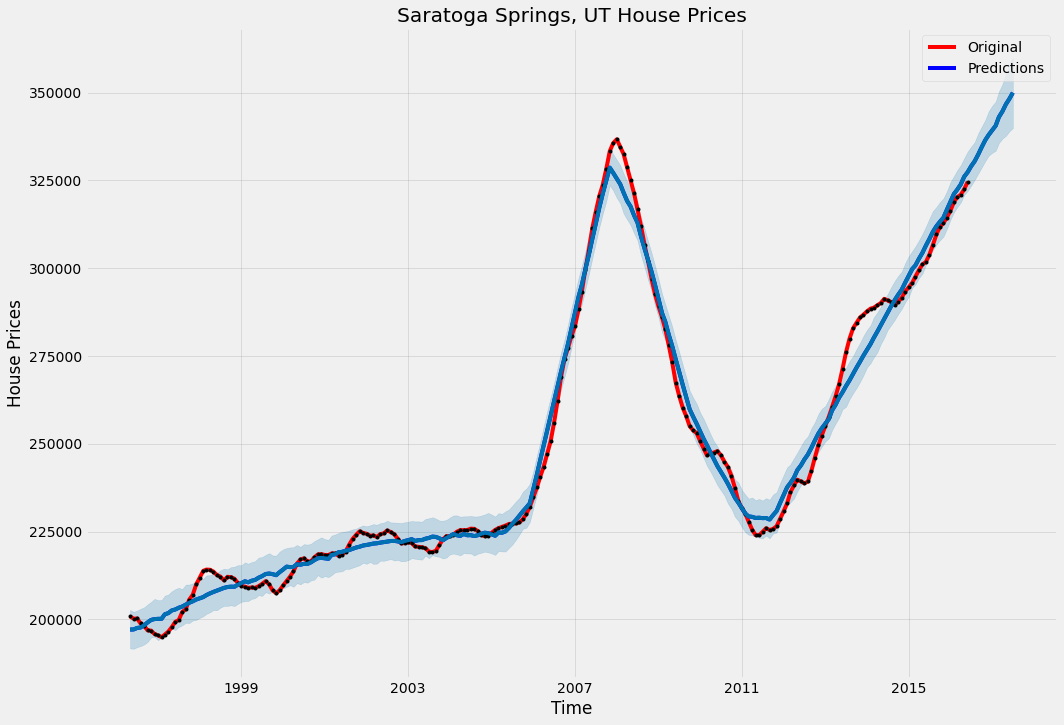

In [26]:
fbprophet_func(Saratoga_proph, city='Saratoga Springs, UT')

RMSE for the Prophet model is 4208.  The SARIMAX model still does better.

### LSTM Model

In [27]:
history = LSTM_func(Saratoga_proph, City=Saratoga, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 [==============================] - 2s 39ms/step - loss: 0.8548 - val_loss: 9.4765
Epoch 2/100
48/48 

Epoch 72/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0498 - val_loss: 0.1427
Epoch 73/100
48/48 [==============================] - 1s 11ms/step - loss: 0.0386 - val_loss: 0.2957
Epoch 74/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0392 - val_loss: 0.0761
Epoch 75/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0497 - val_loss: 0.8985
Epoch 76/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0511 - val_loss: 0.2642
Epoch 77/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0534 - val_loss: 0.2104
Epoch 78/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0471 - val_loss: 0.5671
Epoch 79/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0392 - val_loss: 0.6746
Epoch 80/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0468 - val_loss: 0.4695
Epoch 81/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0334 - val_loss

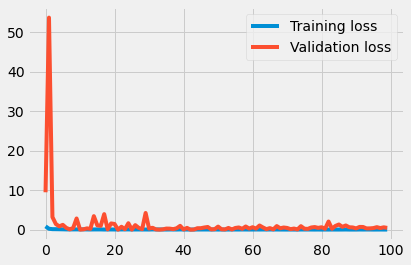

In [28]:
LSTM_val(history)

The LSTM RMSE is still not better than the SARIMAX model.  

## Best Model: SARIMAX with order=(1,0,1), and seasonal_order(1,0,0,12)

In [29]:
yhat_train = sarimax_model2.predict(typ='levels')
yhat_test = sarimax_model2.predict(start=test.index[0], end=test.index[-1], typ='levels')

In [30]:
RMSE_train = np.sqrt(mean_squared_error(train[1:], yhat_train[1:]))
RMSE_test = np.sqrt(mean_squared_error(test, yhat_test))
RMSE_train, RMSE_test

(1524.5707062610588, 61134.14103392236)

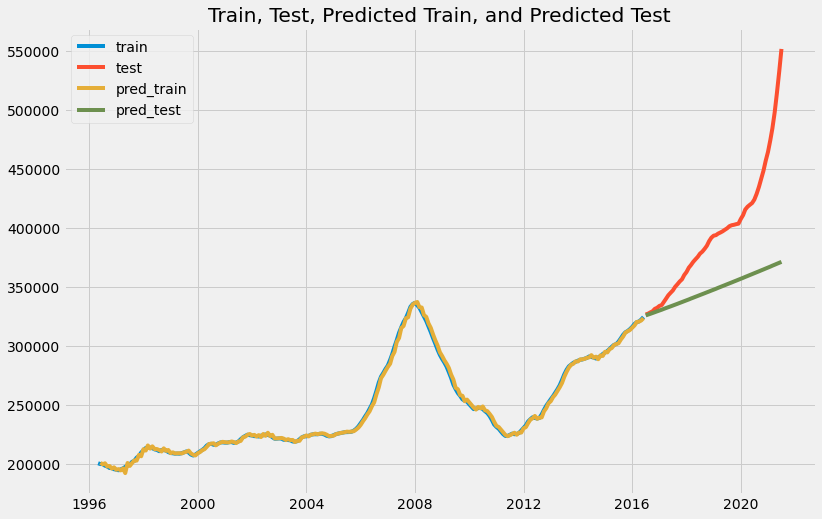

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(yhat_train[1:], label='pred_train')
ax.plot(yhat_test, label='pred_test')
ax.set_title('Train, Test, Predicted Train, and Predicted Test')
ax.legend();

The RMSE on the test data is not great, but let's give the model the full dataset.

In [32]:
sarimax_model_all = SARIMAX(Saratoga, order=(1,0,1), seasonal_order=(1,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_all = sarimax_model_all.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(Saratoga[2:], yhat_all[2:]))
RMSE

1894.8340098558976

The RMSE on all the data is 1895 (after excluding the first two data points where the model has no history to use.)

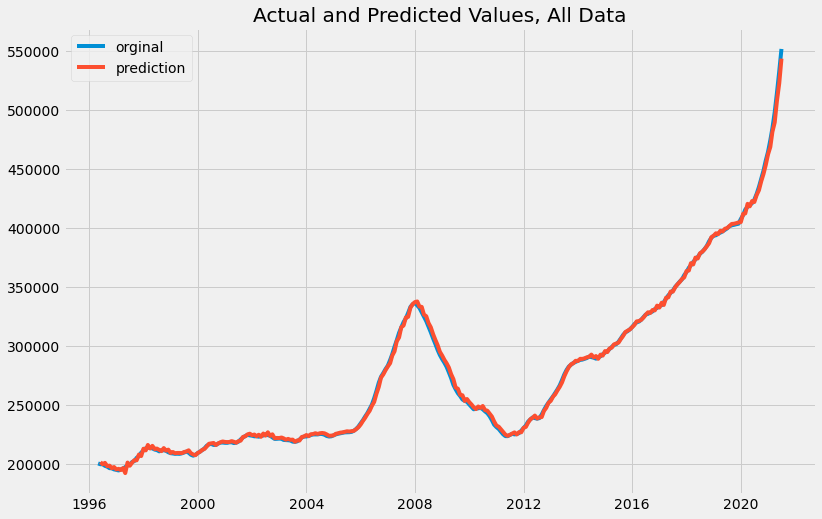

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Saratoga, label='orginal')
ax.plot(yhat_all[1:], label='prediction')
ax.set_title('Actual and Predicted Values, All Data')
ax.legend();

## Best Model Forecast

In [34]:
forecast_sarimax_model_all = sarimax_model_all.forecast(steps=60)

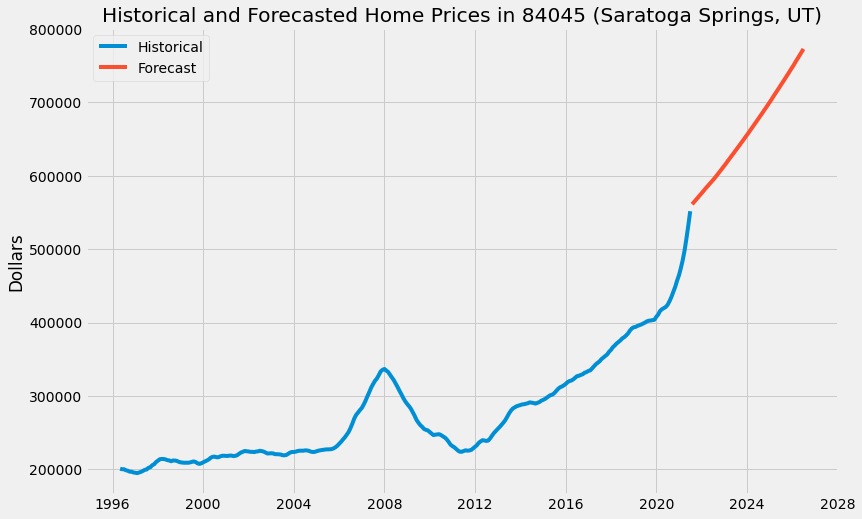

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Saratoga, label='Historical')
ax.plot(forecast_sarimax_model_all, label='Forecast')
ax.set_title('Historical and Forecasted Home Prices in 84045 (Saratoga Springs, UT)')
ax.set_ylabel('Dollars')
ax.legend();

In [36]:
current_price = int(Saratoga['2021-07-01':].value.values)
predicted_price = forecast_sarimax_model_all[-1]
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $551641
Predicted 2026 price:         $772606.3814121848
Predicted five year increase: $220965.3814121848
Predicted five year ROI:      0.40056011321164453


The final model predicts a five year ROI of 40.1%.